In [5]:
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf

Text(0, 0.5, 'Amplitude')

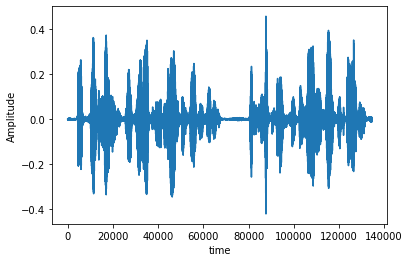

In [9]:
data, _ = sf.read("./LibriSpeech-SI/train/spk001/spk001_002.flac")

%matplotlib inline
plt.plot(range(len(data)), data)
plt.xlabel("time")
plt.ylabel("Amplitude")

Text(0, 0.5, 'Amplitude')

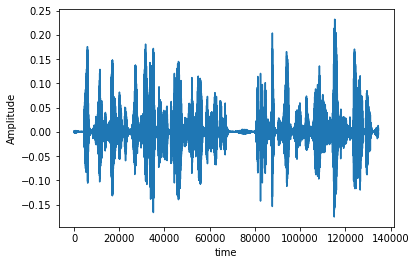

In [10]:
preEmphasis = np.hstack((data[0], data[1:]-0.97*data[:-1]))
plt.plot(range(len(preEmphasis)), preEmphasis)
plt.xlabel("time")
plt.ylabel("Amplitude")